In [1]:
import numpy as np
import matplotlib.pyplot as plt
import CoolProp.CoolProp as CP
import CoolProp.Plots as CPP

In [17]:
#approximating mdot
GPH2Kgs = .00078 #gallons per hour (steam evaporated) to kg/s
mdot_sap_high = 12*GPH2Kgs

Pa = 101.3 * 10**3 # average ambient pressure [Pa]
mdot_sap_low = .001 #[kg/s]
#Qdot_fire = 20000 #[20 kW from stove]

# mdot_sap = mdot_sap_high
mdot_sap = mdot_sap_high

# Setting the width and length of the preheating pan
pre_panL = 1
pre_panW = .5
pre_panA = pre_panL* pre_panW

In [10]:
Tsapi = 278 # [K] about 40F

# Calculate temperature of the steam as the boiling point of sap
sugar_amount = 66.9 # Percent g sugar per 100 g solution for maple syrup [Brix]
kb = 0.51 # molal boiling point elevation[°C*kg/mol]
Tbpe = 0.51 * (sugar_amount / 342.3)/((100-sugar_amount)/1000) # Calculate molality of solution in mols sugar/kg water

Tsteam = 373.15 + Tbpe # Temperature to boil water plus the boiling point elevation due to sugar content
Tsteamcold = 300 # [K] just picked a number
cpsap = 4182 # assume same as water [J/kgK]
cpsteam = 4182 # same as water [J/kgK]

#older pre-heating code?
Qsteamout = mdot_sap * cpsteam * (Tsteam-Tsteamcold)
Qinsap = Qsteamout
Tsapout = Tsapi + Qinsap/(mdot_sap * cpsap)

In [11]:
#calculating the Qdot we need 
hsap = CP.PropsSI('H','P',Pa,'T', Tsapout,'water') #[j/kg]
hsteam = CP.PropsSI('H','P',Pa,'Q', 1 ,'water') #[j/kg]
Qdot_need = mdot_sap_high* (hsteam-hsap)

print(Qdot_need)

21867.004159786702


In [12]:
def simpleEvap(mdot_sap, Tsap, Tsteam=375):
    hsap = CP.PropsSI('H','P',Pa,'T', Tsap,'water') #[j/kg]
    hsteam = CP.PropsSI('H','P',Pa,'T', Tsteam ,'water') #[j/kg]
    Qdot_need = mdot_sap*(hsteam - hsap)
    return Qdot_need

In [13]:
n=50 
mdots = np.linspace(mdot_sap_low, mdot_sap_high, n)
Tsapis = np.linspace(280, 360, n)
results = []
for j in range(0, n):
    if j == 0:
        results = [simpleEvap(mdots[j], Tsapi)]
    else:
        results.append(simpleEvap(mdots[j], Tsapi))

Text(0.5, 1.0, 'Heat Input in Relation to Mass Flow')

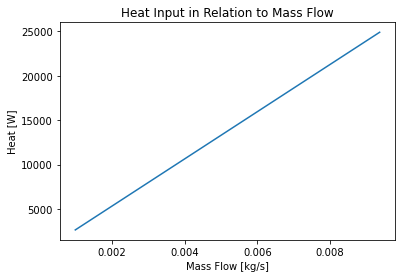

In [14]:
plt.plot(mdots, results)
plt.xlabel('Mass Flow [kg/s]')
plt.ylabel('Heat [W]')
plt.title('Heat Input in Relation to Mass Flow')

Text(0.5, 1.0, 'Heat Input in Relation to Mass Flow')

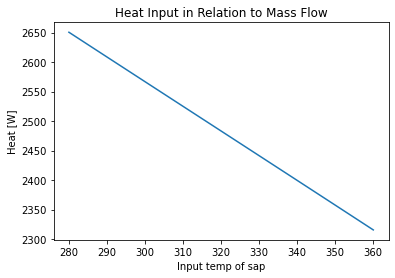

In [15]:
resultsT = []
for j in range(0, n):
    if j == 0:
        resultsT = [simpleEvap(mdot_sap_low, Tsapis[j])]
    else:
        resultsT.append(simpleEvap(mdot_sap_low, Tsapis[j]))
plt.plot(Tsapis, resultsT)
plt.xlabel('Input temp of sap')
plt.ylabel('Heat [W]')
plt.title('Heat Input in Relation to Mass Flow')

In [ ]:
mdots_,Tsapis_ = np.meshgrid(mdots, Tsapis)
result2 = []
m = n-1
for j in range(0, n):
    for i in range(0,n):
        if i ==0:
            newrow = [simpleEvap(mdots[m-j], Tsapis[m-i])]
        else: 
            newrow.append(simpleEvap(mdots[m-j], Tsapis[m-i]))
#         results = np.vstack([results, newrow])
    result2.append(newrow)



In [ ]:
# len(results)
# print(results[2])

In [ ]:
fig = plt.figure()
cs= plt.contourf(mdots_,Tsapis_, result2)
plt.xlabel('Mass flow into pan [kg/s]')
plt.ylabel('Temp of sap entering pan [K]')
plt.title('Heat required to keep boil [Watts]')
fig.colorbar(cs)
plt.show()

In [ ]:
def totalAcresForest(mdot_sap, Ts):
    # Function that calculates total acres of forest needed to sustain maple sugaring at the
    # calculated Qdot from the above model
    
    # Calculate the amount of heat needed per kg sap
    Q_per_kg_sap = simpleEvap(mdot_sap, Ts)/mdot_sap
    
    # Set parameters for sap production
    num_maples = 80 # Number of maples being tapped for sap, set arbitrarily
    sap_per_tree = 50 # kg sap per tree per season, taken from https://en.wikipedia.org/wiki/Maple_syrup#Production
    mass_sap_total = num_maples * sap_per_tree # Total sap to be processed per year
    
    # Calculate total heat needed
    Q_total = mass_sap_total * Q_per_kg_sap
    
    # Total acres wood needed to process sap per year is given by dividing total heat by (heat per kg wood * kg wood per acre)
    
    # Set parameters for fuel production & combustion
    HHV_wood = 16.8 * 1055*10**6/3624.6 # 16.8 million BTU/cord of green sugar maple wood * 1055 MJ per million BTU /3624.6 kg/cord
    # Efficiency given by https://www.uvm.edu/sites/default/files/sappreheaters.pdf
    eff = 0.65 # Percentage efficiency, represents heat loss to outside, exhaust, incomplete combustion, etc. To be replaced
    mdot_forest_growth = 0.375 * 3624.6 # kg wood per acre forest per year
    
    forest_area = Q_total/(HHV_wood * eff * mdot_forest_growth)
    
    return forest_area

In [19]:
#Qin/mdot = Cp(Tout-Tin)
#Qin = hA(Tsapout - Tsapin) 
h = 4
TsapWarm = 368
Q_preIn = h* pre_panA*(TsapWarm - Tsapi)